In [90]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
from matplotlib.colors import ListedColormap

In [91]:
def new_grid(m, n, empty_ratio=0.1):
    '''
    Set up a new grid with some empty spaces.
    empty_ratio: proportion of the grid to be left unpopulated
    '''
    grid = np.ones([m, n])
    num_empty = int(n * m * empty_ratio)
    
    # Randomly assign empty spaces
    empty_positions = np.random.choice(n * m, num_empty, replace=False)
    for idx in empty_positions:
        # Set row index to be integer division by m, remainder is column index 
        grid[idx // m, idx % m] = np.nan 
    
    return grid

def add_amenities(grid, amenities):
    '''
    Add amenities to unpopulated spaces.
    '''
    # Get empty position indices by looking for NaNs
    empty_positions = np.argwhere(np.isnan(grid))
    
    # Number of amenities set to be minimum of entered argument and number of empty slots
    num_amenities = min(amenities, len(empty_positions))
    # Randomly choose from empty slots
    amenity_indices = np.random.choice(len(empty_positions), num_amenities, replace=False)
    # We can remove tgis line later
    print(f"Positions to add amenities: {amenity_indices}")
    
    # Iterate through chosen empty positions to set amenity values
    for idx in amenity_indices:
        position = empty_positions[idx]
        # Use -1 to represent an amenity 
        # This should work since houses will never have a negative price
        grid[position[0], position[1]] = -1  
    
    return grid

def initial_price_dist(m, n, v, amenities, empty_ratio=0.1):
    '''
    Initialize grid with prices, unpopulated spaces and amenities 
    '''
    houses = v * new_grid(m, n, empty_ratio)
    # Add "amenities" number of amenities within the empty grid points
    houses = add_amenities(houses, amenities)

    return houses


def plot_grid(grid):
    '''
    Plot grid with unpopulated squares in gray, amenities in blue, and high values in yellow.
    '''

    # Colour map for house prices only
    cmap = plt.cm.cividis.copy()
    
    # Set pink for NaN values 
    cmap.set_bad(color='lightpink')
    
    # Calculate the minimum and maximum values in the grid, excluding NaN and -1 values (amenities)
    non_empty_values = grid[(grid != -1)]
    min_value = np.nanmin(non_empty_values)
    max_value = np.nanmax(non_empty_values)
    # Plot house grid using min_value for vmin and max_value for vmax 
    # This is to make sure NaNs and amenities don't distort scale
    img = plt.imshow(grid, cmap=cmap, vmin=min_value, vmax=max_value, interpolation='nearest') 
    
    # Colour map which will set only -1 to red and the rest to transparent white
    # All entries start as transparent 
    new_colours = np.ones((256, 4))  
    # Set the first color to black (for value -1)
    new_colours[0] = [1, 0, 0, 1]  
    # Set all other colors to transparent white
    new_colours[1:] = [1, 1, 1, 0]  
    new_cmap = ListedColormap(new_colours)
    # Make a mask for amenities and set them to a different coluor (used blue)
    amenities_mask = grid != -1
    plt.imshow(amenities_mask, cmap=new_cmap)  

    # Add colour bar for the house price values
    plt.colorbar(img)  

    return img
    
def initial_affluence_dist(initial_prices, a, p):
    '''
    Initialize affluence of householders as their own grid corresponding to which house they are in
    Inputs:
    a (array): affluence group parameters 
    p (array): proportions of affluence groups 
    '''
    m = initial_prices.shape[0]
    n = initial_prices.shape[1]
    
    # Initialize an empty affluence grid with NaNs for empty cells
    affluence_grid = np.full(initial_prices.shape, np.nan)  
    
    # Loop through each cell in the house_vals grid
    for i in range(m):
        for j in range(n):
            # Only assign affluence if the square is populated (-1 < 0, otherwise point populated)
            if initial_prices[i, j] > 0: 
                affluence_grid[i, j] = np.random.choice(a, p=p)

    return affluence_grid

In [92]:
# Functions for calculating house values
       
# Note: this is including the house itself. Do we want that?        
def neighborhood_average(i, j, m, n, grid):
    '''
    Calculate average prices depending on where you are in the grid
    '''
    row_min = max(0, i - 2)
    row_max = min(m-1, i + 2)
    
    col_min = max(0, j - 2)
    col_max = min(n-1, j + 2)
    
    neighborhood = grid[row_min:row_max+1, col_min:col_max+1]
    
    # Mask out NaNs and amenities
    valid_neighbors = neighborhood[(~np.isnan(neighborhood)) & (neighborhood != -1)]
    
    # Calculate the mean of valid neighbors (ignores empty squares and amenities)
    if valid_neighbors.size > 0:
        return valid_neighbors.mean()
    else:
        # If the square is empty or an amenity it stays the same 
        return grid[i, j]
       
def amenities_impact(house_vals, x, r):
    '''
    Calculate average prices depending on where you are in the grid
    '''
    i, j = x[0], x[1]
    m, n = house_vals.shape[0], house_vals.shape[1]
    
    row_min = max(0, i - r)
    row_max = min(m-1, i + r)
    
    col_min = max(0, j - r)
    col_max = min(n-1, j + r)
    
    value_added = 0
    
    for k in range(row_min,row_max+1):
        for l in range(col_min,col_max+1):
            if house_vals[k, l] == -1:
                distance = abs(k - i) + abs(l - j)
                value_added += max(0, r + 1 - distance)
                
    return value_added

def update_house_prices(house_vals, affluence_grid, weights, r):
    '''
    Update all of the house values by calculating new value using householder affluence and neighborhood average price
    Excludes amenities (-1) and empty spaces (NaN).
    '''
    updated_houses = house_vals.copy()
    
    m = house_vals.shape[0]
    n = house_vals.shape[1]

    for i in range(m):
        for j in range(n):
            # Skip updates for empty spaces and amenities
            if np.isnan(house_vals[i, j]) or house_vals[i, j] == -1:
                # Go to next iteration if NaN or -1
                continue
            # Otherwise update as normal
            updated_houses[i, j] = (affluence_grid[i, j] 
            + weights[0] * neighborhood_average(i, j, m, n, house_vals) 
            + weights[1] * amenities_impact(house_vals, (i, j), r))

    return updated_houses

In [93]:
# Functions for choosing a random position relative to a position and considering a swap between two the positions 

def random_position(i, j, m, n):
    '''
    Pick a random grid point to compare to 
    '''
    # Ensures this will keep going until the position is not the same as the one we want to comoare to
    while True:
        rand_row = np.random.randint(0, m - 1)
        rand_col = np.random.randint(0, n - 1)
        # Ensures it is not the same as the current position
        if (rand_row, rand_col) != (i, j):
            return rand_row, rand_col
    
# Need to update this function to value amenities!!!
def perform_swaps(house_vals, affluence_grid, x, y):
    '''
    Check to see if we should move the householders and then move if needed.
    Inputs:
    house_vals (array): grid of house values
    affluence_grid (array): grid of affluence values
    x, y (tuples): tuples representing indices of the two householders to compare
    '''
    
    # Calculate the change in "satisfaction" if two householders swap
    delta = ((affluence_grid[x] - house_vals[x])**2 + (affluence_grid[y] - house_vals[y])**2 
             - (affluence_grid[x] - house_vals[y])**2 - (affluence_grid[y] - house_vals[x])**2)

    # Switch householders if swapping improves satisfaction
    if delta > 0:
        affluence_grid[x], affluence_grid[y] = affluence_grid[y], affluence_grid[x]

    return affluence_grid

In [94]:
# Iteration function 

def new_iteration(house_vals, affluence_grid):
    '''
    Perform swaps on the affluence grid and calculate the new house values
    '''
    
    m = house_vals.shape[0]
    n = house_vals.shape[1]
        
    # Iterate over each populated element in the array
    for i in range(m):
        for j in range(n):
            # Skip unpopulated or amenity squares
            if house_vals[i, j] <= 0:
                # Continue skips to next iteration
                continue

            # Find a random populated cell to compare for a potential swap
            while True:
                rand_i, rand_j = random_position(i, j, m, n)
                # Only swap with another populated square
                if house_vals[rand_i, rand_j] > 0:
                    # While loop exited only if the square is not NaN or -1
                    break
        
            x = (i,j)
            y = (rand_i, rand_j)
            affluence_grid = perform_swaps(house_vals, affluence_grid, x, y)
            
    # Update house prices
    house_vals = update_house_prices(house_vals, affluence_grid, weights, r)

    return house_vals, affluence_grid

Positions to add amenities: [250 621 534 591 523 445  43  11 595 139 141 398 130 169 479 443 415 104
 623 494 611 166 446 170 154  37 346 147 392 202 190 604 391 457 360 511
  71  29 281 551 495 298 186 332 259   1 327 295  61 207 498 455 504  80
 101 573 131  77 508 484 545 334 431 157 402  70 232 451 239 358 272  51
 148 372 401]


array([[nan,  5.,  5., ...,  5., nan,  5.],
       [ 5., -1.,  5., ...,  5.,  5.,  5.],
       [ 5.,  5., nan, ...,  5.,  5., nan],
       ...,
       [ 5., nan,  5., ...,  5.,  5., nan],
       [ 5.,  5.,  5., ..., nan,  5.,  5.],
       [ 5.,  5., -1., ...,  5.,  5.,  5.]])

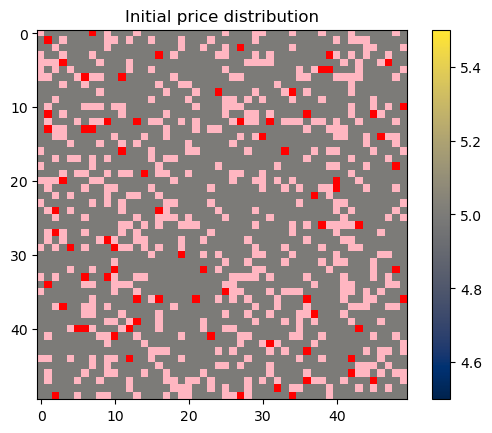

Initial affluence distribution:


array([[nan, 0.1, 0.1, ..., 0.1, nan, 0.5],
       [1. , nan, 0.1, ..., 0.5, 0.5, 0.5],
       [0.1, 0.1, nan, ..., 0.1, 0.5, nan],
       ...,
       [0.5, nan, 0.5, ..., 0.5, 0.5, nan],
       [0.5, 0.1, 0.1, ..., nan, 0.1, 0.1],
       [0.1, 0.1, nan, ..., 0.1, 0.1, 0.5]])

In [95]:
# Set board size
m = 50
n = 50

# Set parameters
a = [1,0.5,0.1] # Affluence group parameters 
p = [0.1, 0.4, 0.5] # Initial affluence proportions 
v = 5 # Initial house price
weights = [0.9, 1] # Inflationary parameter
amenities = 75
r = 4

# Initialize house price grid 
initial_prices = initial_price_dist(m, n, v, amenities, empty_ratio=0.25)

display(initial_prices)
plot_grid(initial_prices)
plt.title("Initial price distribution")
plt.show()

print("Initial affluence distribution:")
# Initialize affluence grid 
affluence_grid = initial_affluence_dist(initial_prices, a, p)
display(affluence_grid)

Testing first house values calculation:


array([[ nan,  8.6,  7.6, ...,  5.6,  nan,  5. ],
       [ 9.5, -1. ,  9.6, ...,  7. ,  6. ,  5. ],
       [ 7.6,  9.6,  nan, ...,  7.6,  7. ,  nan],
       ...,
       [ 6. ,  nan,  8. , ...,  8. ,  7. ,  nan],
       [ 7. ,  7.6,  8.6, ...,  nan,  5.6,  4.6],
       [ 7.6,  8.6, -1. , ...,  5.6,  4.6,  5. ]])

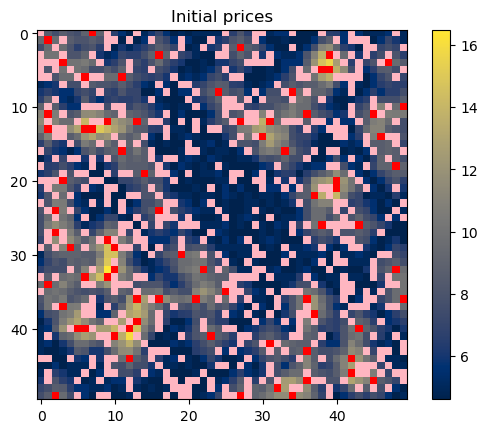

In [96]:
# Test the new functions

house_vals = update_house_prices(initial_prices, affluence_grid, weights, r) 
# Plot the initial house values 
fig, ax = plt.subplots()
img = plot_grid(house_vals)
plt.title(f"Initial prices")

print("Testing first house values calculation:")
display(house_vals)

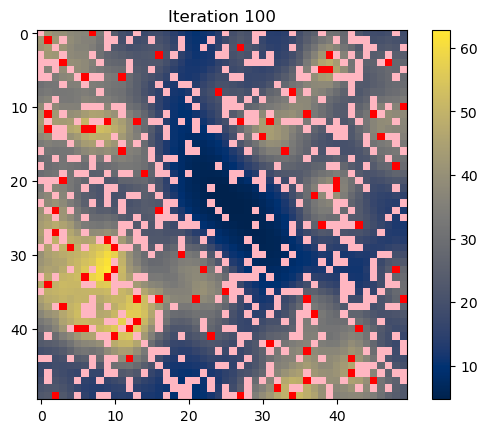

In [97]:
# Animation cell 

# Do the first house values calculation
house_vals = update_house_prices(initial_prices, affluence_grid, weights, r)

# Plot the initial house values 
fig, ax = plt.subplots()
img = plot_grid(house_vals)
plt.title(f"Initial prices")
plt.pause(0.5) 
clear_output(wait=True) 

# Plot the iterations 
n_steps = 100
for i in range(n_steps):
   house_vals, affluence_grid = new_iteration(house_vals, affluence_grid)
   img = plot_grid(house_vals)  
   plt.title(f"Iteration {i + 1}")
   plt.pause(0.01)  
   clear_output(wait=True) 